# Grid generation and other things ...

In [2]:
import ipyparallel as ipp

cluster = ipp.Cluster(engines="mpi", n=6).start_and_connect_sync()
%autopx

Starting 6 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

%autopx enabled


Setting up layout and number of grid points per tile

In [65]:
%%capture
nx = 20
ny = 20
nz = 79
""" (int): number of points per tile in each direction """

nhalo = 3
""" (int): number of halo points in x- and y- directions """

layout = (1, 1)
""" (int, int): how many parts each tile is split into? """

backend = "numpy"
""" (str): """

What does this next cell do?

In [66]:
from mpi4py import MPI

mpi_comm = MPI.COMM_WORLD
mpi_size = mpi_comm.Get_size()
mpi_rank = mpi_comm.Get_rank()

What does this next cell do?

In [67]:
from pace.util import CubedSpherePartitioner, TilePartitioner

partitioner = CubedSpherePartitioner(TilePartitioner(layout))

What does this next cell do?

In [68]:
from pace.util import CubedSphereCommunicator

communicator = CubedSphereCommunicator(mpi_comm, partitioner)

What does this next cell do?

In [69]:
from pace.util import SubtileGridSizer

sizer = SubtileGridSizer.from_tile_params(
    nx_tile=nx,
    ny_tile=ny,
    nz=nz,
    n_halo=nhalo,
    extra_dim_lengths={},
    layout=layout,
    tile_partitioner=partitioner.tile,
    tile_rank=communicator.tile.rank,
)

What does this next cell do?

In [70]:
from pace.util import QuantityFactory

quantity_factory = QuantityFactory.from_backend(
    sizer=sizer, 
    backend=backend
    )



What does this next cell do?

In [71]:
from pace.util.grid import MetricTerms

metric_terms = MetricTerms(
    quantity_factory=quantity_factory, 
    communicator=communicator
    )
    

What does this next cell do?

In [72]:
from pace.util.grid import DampingCoefficients

damping_coefficients = DampingCoefficients.new_from_metric_terms(metric_terms)
    

[stderr:2] /home/ajdas/pace/pace-util/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


[stderr:5] /home/ajdas/pace/pace-util/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


What does this next cell do?

In [73]:
from pace.util.grid import GridData

grid_data = GridData.new_from_metric_terms(metric_terms)    

What does this next cell do?

In [74]:
from pace.dsl.dace.dace_config import DaceConfig, DaCeOrchestration

dace_config = DaceConfig(
    communicator=communicator, 
    backend=backend, 
    orchestration=DaCeOrchestration.Python
    ) 

What does this next cell do?

In [75]:
from pace.dsl.stencil_config import CompilationConfig, RunMode

compilation_config = CompilationConfig(backend=backend, 
    rebuild=True, 
    validate_args=True, 
    format_source=False, 
    device_sync=False, 
    run_mode=RunMode.BuildAndRun, 
    use_minimal_caching=False, 
    communicator=communicator,
)

What does this next cell do?

In [76]:
from pace.dsl.stencil import StencilConfig

stencil_config = StencilConfig(
    compare_to_numpy=False,
    compilation_config=compilation_config,
    dace_config = dace_config
)

What does this next cell do?

In [77]:
from pace.dsl.stencil import GridIndexing

grid_indexing = GridIndexing.from_sizer_and_communicator(
        sizer=sizer, 
        cube=communicator
    )

# set the domain so there is only one level in the vertical -- forced
domain = grid_indexing.domain
domain_new = list(domain)
domain_new[2] = 1
domain_new = tuple(domain_new)

grid_indexing.domain = domain_new

What does this next cell do?

In [78]:
from pace.dsl.stencil import StencilFactory

stencil_factory = StencilFactory(
    config=stencil_config, 
    grid_indexing=grid_indexing
    )

Get longitude and latitude information from grid_data, and gather them all on rank 0.

In [79]:
import numpy as np
from pace.util import Quantity

lon = Quantity(
    grid_data.lon.data * 180 / np.pi,
    ("x_interface", "y_interface"),
    "degrees",
    (nhalo, nhalo),
    (nx+1, ny+1),
    backend,
)

lat = Quantity(
    grid_data.lat.data * 180 / np.pi,
    ("x_interface", "y_interface"),
    "degrees",
    (3, 3),
    (nx+1, ny+1),
    backend,
)

lon_gather = communicator.gather(lon)
lat_gather = communicator.gather(lat)


Plot grid map (edges of cells) for chosen domain size.

[output:0]

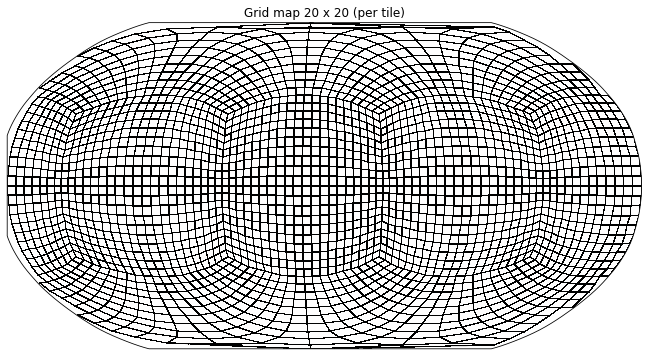

In [86]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from fv3viz import pcolormesh_cube

if mpi_rank == 0:
    field = np.zeros(lon_gather.data.shape)[:, :-1, :-1]

    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())

    pcolormesh_cube(lat_gather.data, lon_gather.data, field, 
        cmap="bwr", vmin=-1, vmax=1, edgecolor="k", linewidth=0.1,
    )

    ax.set_title('Grid map %s x %s (per tile)' % (nx, ny))

    plt.show()



Get dx and dy information from grid_data, and gather them all on rank 0.
Plot them on a map.

[output:0]

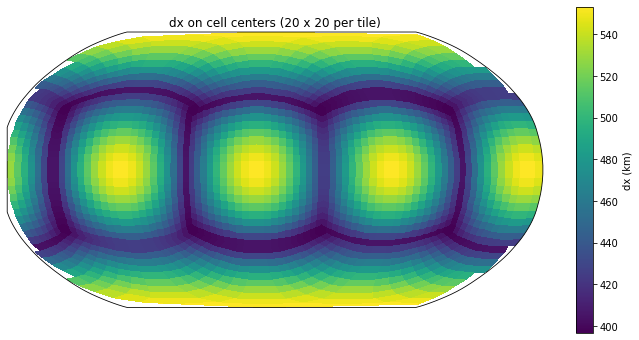

[output:0]

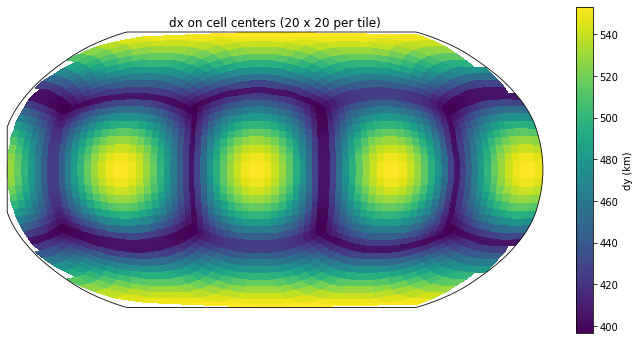

In [104]:
dx = Quantity(
    grid_data.dxa.data,
    ("x", "y"),
    "m",
    (nhalo, nhalo),
    (nx, ny),
    backend,
)

dy = Quantity(
    grid_data.dya.data,
    ("x", "y"),
    "m",
    (nhalo, nhalo),
    (nx, ny),
    backend,
)

dx_gather = communicator.gather(dx)
dy_gather = communicator.gather(dy)

if mpi_rank == 0:
    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())

    f1 = pcolormesh_cube(lat_gather.data, lon_gather.data, dx_gather.data/1e3)

    plt.colorbar(f1, label='dx (km)')

    ax.set_title('dx on cell centers (%s x %s per tile)' % (nx, ny))


    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())

    f1 = pcolormesh_cube(lat_gather.data, lon_gather.data, dy_gather.data/1e3)

    plt.colorbar(f1, label='dy (km)')

    ax.set_title('dx on cell centers (%s x %s per tile)' % (nx, ny))

    plt.show()